In [1]:
import numpy as np
import pandas as pd

import math
import gc
gc.collect()


0

### Load Data

In [2]:
seasons = list(range(2009,2019)) # creates list of years through 2018

# merge seasons into one df
df = pd.DataFrame()
for season in seasons:
    path = './../data/nflscrapR-data/play_by_play_data/regular_season/reg_pbp_'+str(season)+'.csv'
    season_df = pd.read_csv(path)
    season_df['season'] = season
    df = pd.concat([df, season_df], axis=0)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (42,166,167,174,175,178,179,182,183,188,189,190,191,203,204,205,231,232,233,238,240,241) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (37,38,39,42,46,47,166,167,168,169,172,173,174,175,176,177,178,179,182,183,184,185,188,189,190,191,192,193,194,195,198,199,203,204,205,224,225,226,227,231,232,233,238,240,241,244,245,246,250) have mixed types. Speci

### Clean Steps

In [105]:
# standardize jaguars abbrev
df['posteam']=df['posteam'].replace('JAC','JAX')

# some typical cleaning that I don't do here

# drop redzone plays & inside own 5
# df = df.loc[(df.yardline_100 > 20) & (df.yardline_100 < 95)]

# drop extreme win probabilities (about 4% of plays)
# df = df.loc[(df['wp']>=0.05) | (df['wp']<=0.95)]

# drop afc and nfc

conf_teams = ['AFC','NFC','IRV','APR','NPR','RIC','SANS']
df = df.loc[~df['posteam'].isin(conf_teams)]
print(len(df))

452661


In [106]:
# eliminate special teams
pos_df = df.loc[(df['play_type']=='run') | (df['play_type']=='pass')]
print(len(pos_df))

321676


In [107]:
pos_df['first_down'] =  pos_df['first_down_rush'] + pos_df['first_down_pass']
print(len(pos_df))
pos_df = pos_df.loc[pos_df['first_down']<2]
print(len(pos_df))
pos_df = pos_df.dropna(subset=['first_down'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


321676
321675


In [108]:
# print(list(df))

pos_df = pos_df[['play_type','yards_gained','first_down', 'complete_pass', 'fumble','touchdown','safety','two_point_conv_result','epa','wpa']]

pos_df['two_point_conv_result'] = pos_df['two_point_conv_result'].apply(lambda x: 1 if x == 'success' else 0)

pos_df = pos_df.rename(columns={'complete_pass':'reception'})

# drop incompletions when calculating positional lpayers
pos_df = pos_df.loc[(pos_df['reception']==1) | (pos_df['play_type']=='run')]

pos_df = pos_df.drop(columns=['play_type'])

print(len(pos_df))
pos_df = pos_df.dropna()
print(len(pos_df))

243456
241824


### Heatmap

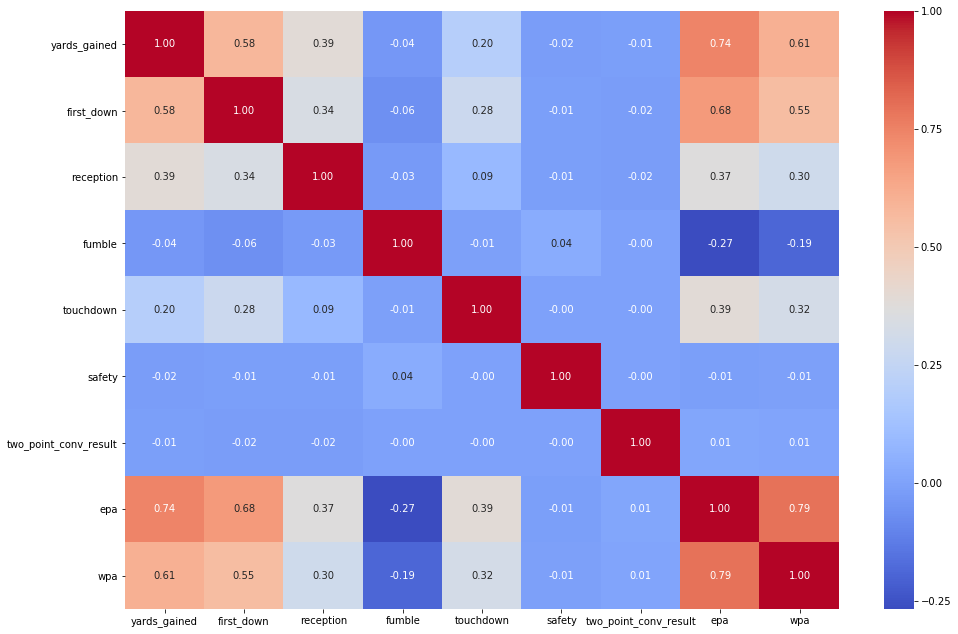

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

# change gc column order

fig, ax = plt.subplots(figsize=(16, 11))

#saleprice correlation matrix
sns.heatmap(pos_df.corr(),
            cmap='coolwarm',
            annot=True,
            fmt=".2f",
            annot_kws={'size':10},
            cbar=True,
            square=False)

fig.savefig('./plots/Pos_Heatmap.png', bbox_inches='tight')
plt.show()

In [114]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression,Lasso 
from sklearn.metrics import log_loss

X_df = pos_df[['yards_gained','first_down', 'reception', 'fumble','touchdown','two_point_conv_result']]
X = X_df.values
y = pos_df['epa'].values
y2 = pos_df['wpa'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=17)

regressor = LinearRegression()
regressor.fit(X, y)

regressor2 = LinearRegression()
regressor2.fit(X, y2)

print("epa",regressor.score(X, y))
print("wpa",regressor2.score(X, y2))

multiplier = 0.1/regressor.coef_[0]
print("epa multiplier",multiplier)

multiplier2 = 0.1/regressor2.coef_[0]
print("wpa multiplier",multiplier2)

epa = regressor.coef_ * multiplier
wpa = regressor2.coef_ * multiplier2

wpa_rounded = [0.1,1,0.2,-3,2,2]

score_df = pd.DataFrame(zip(X_df.columns,epa, wpa, wpa_rounded), columns=['Stat','EPA fpts', 'WPA fpts', 'WPA rounded'])

score_df = score_df.reset_index()
score_df = score_df.drop(columns=['index'])
score_df = score_df.round(2)
score_df

epa 0.7342894707461963
wpa 0.4806009466859058
epa multiplier 1.420987763553612
wpa multiplier 51.569193220010355
                    Stat  EPA fpts  WPA fpts
0           yards_gained      0.10      0.10
1             first_down      1.13      1.12
2              reception      0.18      0.15
3                 fumble     -3.43     -2.90
4              touchdown      1.70      1.71
5                 safety      0.96      1.17
6  two_point_conv_result      2.06      1.96


In [117]:
qb_df = df.loc[df['play_type']=='pass']

In [118]:
qb_df = qb_df[['yards_gained','first_down_pass', 'complete_pass','incomplete_pass','fumble','sack','interception','touchdown','two_point_conv_result','epa','wpa']]

qb_df['two_point_conv_result'] = qb_df['two_point_conv_result'].apply(lambda x: 1 if x == 'success' else 0)


def drop_receiver_fumbles(complete_pass,fumble):
    if complete_pass == 0:
        if fumble == 1:
            return 1
    return 0

# drop receiver fumbles (when there is a completed pass AND a fumble in the same play, fumble = 0)
print(qb_df['fumble'].sum())
qb_df['fumble'] = qb_df.apply(lambda row: drop_receiver_fumbles(row['complete_pass'],row['fumble']),axis=1)
print(qb_df['fumble'].sum())


3106.0
1828


In [121]:
print(len(qb_df))
qb_df = qb_df.dropna()
print(len(qb_df))

X_df = qb_df[['yards_gained','first_down_pass', 'complete_pass','fumble','sack','interception','touchdown','two_point_conv_result']]
X = X_df.values
y = qb_df['epa'].values
y2 = qb_df['wpa'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=17)

regressor = LinearRegression()
regressor.fit(X, y)

regressor2 = LinearRegression()
regressor2.fit(X, y2)

print("epa",regressor.score(X, y))
print("wpa",regressor2.score(X, y2))

multiplier = 0.1/regressor.coef_[0]
print("epa multiplier",multiplier)

multiplier2 = 0.1/regressor2.coef_[0]
print("wpa multiplier",multiplier2)

epa = regressor.coef_ * multiplier
wpa = regressor2.coef_ * multiplier2

wpa_rounded = [0.1,1.5,0.5,-2,-0.3,-4,2,3]

score_df = pd.DataFrame(zip(X_df.columns,epa, wpa, wpa_rounded), columns=['Stat','EPA fpts', 'WPA fpts', 'WPA rounded'])

score_df = score_df.reset_index()
score_df = score_df.drop(columns=['index'])
score_df = score_df.round(2)
score_df

186840
186840
epa 0.7706235323737743
wpa 0.5407277469735939
epa multiplier 1.5470164568183362
wpa multiplier 55.06756089003045
                    Stat  EPA fpts  WPA fpts  WPA rounded
0           yards_gained      0.10      0.10          0.1
1        first_down_pass      1.53      1.48          1.5
2          complete_pass      0.60      0.58          0.5
3                 fumble     -2.60     -1.78         -2.0
4                   sack     -0.37     -0.27         -0.3
5           interception     -5.58     -4.15         -4.0
6              touchdown      1.43      1.77          2.0
7  two_point_conv_result      2.74      2.62          3.0
